# CNN 구현 :  fashion_mnist dataset 사용
### label : class
* 0 : T-shirt
* 1 : Trouser
* 2 : Pullover
* 3 : Dress
* 4 : Coat
* 5 : Sandal
* 6 : Shirt
* 7 : Sneaker
* 8 : Bag
* 9 : Ankle Boot

In [1]:
# 라이브러리 호출
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms # library for data preprocessing
from torch.utils.data import Dataset, DataLoader

In [2]:
# CPU/GPU 장치 확인
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
# fasion_mnist 데이터셋 내려받기
train_dataset = torchvision.datasets.FashionMNIST("./data",download=True,transform=transforms.Compose([transforms.ToTensor()]))
test_dataset = torchvision.datasets.FashionMNIST("./data",download=True,train=False,transform=transforms.Compose([transforms.ToTensor()]))

In [4]:
print(train_dataset)
print(test_dataset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )


In [5]:
imgex = train_dataset[0][0][0,:,:]
print(imgex.shape)

torch.Size([28, 28])


In [6]:
# fashion_mnist 데이터를 DataLoader에 전달 : 내려받은 fashion_mnist 데이터를 메모리로 불러오기 위함
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=100)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=100)

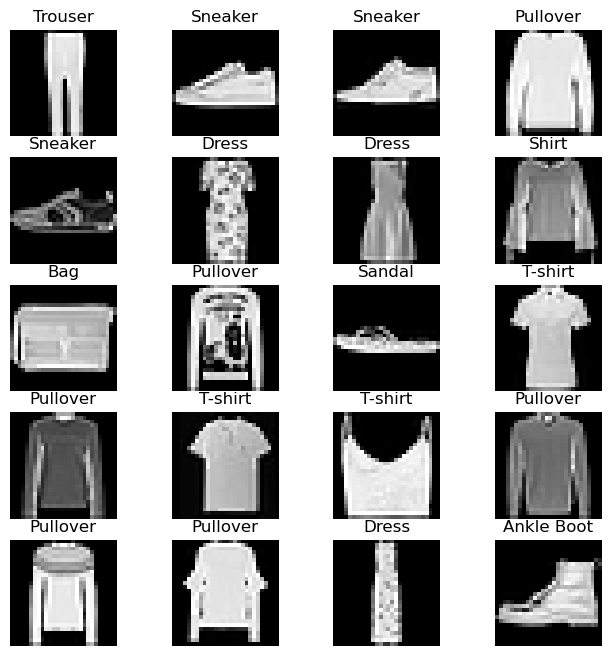

In [7]:
# 분류에 사용될 클래스 정의
labels_map = {0:'T-shirt', 1:'Trouser', 2:'Pullover', 3:'Dress', 4:'Coat', 5:'Sandal', 6:'Shirt', 7:'Sneaker', 8:'Bag', 9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8)); # figure 인스턴스 생성
columns = 4;
rows = 5;
for i in range(1,columns*rows+1):
    img_xy = np.random.randint(len(train_dataset)); # 랜덤으로 라벨 하나를 추출
    img = train_dataset[img_xy][0][0,:,:] # 랜덤 데이터 -> 이미지/라벨 중 이미지 -> (1,28,28)에서 (28,28)만 가져옴
    fig.add_subplot(rows,columns,i) # 위에서부터 한줄씩 subplot 채워나감
    plt.title(labels_map[train_dataset[img_xy][1]]) # (데이터 -> 이미지/라벨 중 라벨)에 해당하는 클래스명을 title로 지정
    plt.axis('off')
    plt.imshow(img,cmap='gray')
plt.show()

In [8]:
# 심층 신경망 모델 생성 (ConvNet이 적용되지 않은 네트워크)
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN,self).__init__()
        self.fc1 = nn.Linear(in_features=784,out_features=256)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=256,out_features=128)
        self.fc3 = nn.Linear(in_features=128,out_features=10)
        
    def forward(self,input_data):
        out = input_data.view(-1,784)
        out = F.relu(self.fc1(out))
        out = self.drop(out)
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        return out

In [9]:
# 심층 신경망에서 필요한 파라미터 정의
learning_rate = 0.001;
model = FashionDNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate);
print(model)

FashionDNN(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (drop): Dropout(p=0.25, inplace=False)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
)


In [10]:
# 심층 신경망을 이용한 모델 학습 : 심층 신경망에 데이터를 적용하여 모델을 학습시킨다
num_epochs = 5
count = 0

loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count%50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs,1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
            
            accuracy = correct * 100 / total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
        
        if not (count%500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count,loss.data,accuracy))

Iteration: 500, Loss: 0.5918741822242737, Accuracy: 83.26000213623047%
Iteration: 1000, Loss: 0.4957016408443451, Accuracy: 84.54000091552734%
Iteration: 1500, Loss: 0.31600314378738403, Accuracy: 84.7300033569336%
Iteration: 2000, Loss: 0.38084834814071655, Accuracy: 85.18000030517578%
Iteration: 2500, Loss: 0.3059979975223541, Accuracy: 86.33999633789062%
Iteration: 3000, Loss: 0.2995274066925049, Accuracy: 86.13999938964844%


In [ ]:
print(accuracy_list)

In [11]:
# 합성곱 네트워크 생성
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout2d(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0),-1)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        return out

In [12]:
# 합성곱 네트워크를 위한 파라미터 정의
learning_rate = 0.001;
model = FashionCNN();
model.to(device)

criterion = nn.CrossEntropyLoss();
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate);
print(model)

FashionCNN(
  (layer1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=2304, out_features=600, bias=True)
  (drop): Dropout2d(p=0.25, inplace=False)
  (fc2): Linear(in_features=600, out_features=120, bias=True)
  (fc3): Linear(in_features=120, out_features=10, bias=True)
)


In [13]:
# 모델 학습 및 성능 평가 
num_epochs = 5
count = 0
loss_list = []
iteration_list = []
accuracy_list = []

predictions_list = []
labels_list = []

for epoch in range(num_epochs):
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        train = Variable(images.view(100,1,28,28))
        labels = Variable(labels)
        
        outputs = model(train)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        count += 1
        
        if not (count % 50):
            total = 0
            correct = 0
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                labels_list.append(labels)
                test = Variable(images.view(100,1,28,28))
                outputs = model(test)
                predictions = torch.max(outputs, 1)[1].to(device)
                predictions_list.append(predictions)
                correct += (predictions == labels).sum()
                total += len(labels)
                
            accuracy = correct*100/total
            loss_list.append(loss.data)
            iteration_list.append(count)
            accuracy_list.append(accuracy)
            
        if not (count % 500):
            print("Iteration: {}, Loss: {}, Accuracy: {}%".format(count, loss.data, accuracy))

/Users/kch/opt/anaconda3/envs/DLWithPyTorch/lib/python3.9/site-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Iteration: 500, Loss: 0.44316962361335754, Accuracy: 87.44999694824219%
Iteration: 1000, Loss: 0.3580792248249054, Accuracy: 87.5%
Iteration: 1500, Loss: 0.320196270942688, Accuracy: 87.29000091552734%
Iteration: 2000, Loss: 0.2127445936203003, Accuracy: 88.83000183105469%
Iteration: 2500, Loss: 0.1588980108499527, Accuracy: 89.27999877929688%
Iteration: 3000, Loss: 0.17795534431934357, Accuracy: 90.5%
